In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import pytorch_lightning as L
import torch
import torchmetrics
from torch.utils.data import DataLoader, Dataset, random_split

F = 250  # frequency - 250 Hz
N = 500  # chunk size = 500 (2 seconds)
all_labels = [
    "NCH_002",
    "NCH_004",
    "NCH_011",
    "NCH_012",
    "NCH_013",
    "NCH_015",
    "NCH_018",
    "NCH_020",
    "NCH_008",
    "NCH_014",
    "NCH_016",
    "NCH_017",
    "NCH_019",
    "NCH_021",
    "NCH_022",
    "NCH_023",
    "NCH_026",
    "NCH_027",
    "NCH_028",
    "NCH_029",
    "NCH_024",
    "NCH_025",
    "NCH_005",
    "NCH_007",
]
train_labels = dict(
    NCH_002=1,
    NCH_004=1,
    NCH_011=1,
    NCH_012=1,
    NCH_013=1,
    NCH_015=1,
    NCH_018=1,
    NCH_020=1,
    NCH_008=0,
    NCH_014=0,
    NCH_016=0,
    NCH_017=0,
    NCH_019=0,
    NCH_021=0,
    NCH_022=0,
    NCH_023=0,
    NCH_026=0,
    NCH_027=0,
    NCH_028=0,
    NCH_029=0,
)
holdout_labels = dict(
    NCH_024=1,
    NCH_025=1,
    NCH_005=0,
    NCH_007=0,
)

In [2]:
class EEGDataset(Dataset):
    data_dir = (
        "/Users/yasith/Library/CloudStorage/OneDrive-OldDominionUniversity/Documents/NIRDS/Datasets/EEG and IRT/EEG_TXT"
    )
    path = Path(data_dir)

    def __init__(self, train=True, transform=None, target_transform=None) -> None:
        super().__init__()
        self.transform = transform
        self.target_transform = target_transform
        inputs = []
        targets = []
        sources = []
        pool = train_labels if train else holdout_labels
        for source in pool:
            data = pd.read_csv(self.path / f"{source}.txt", sep=r"\s+", index_col="Time", dtype=float).to_numpy()
            # break into chunks of size N
            trim = len(data) % N
            if trim > 0:
                front = trim // 2
                back = trim - front
                data = data[front:-back]
            bag = data.reshape((-1, N, 28))
            print(source, bag.shape, bag.dtype)
            if bag.shape[0] == 0:
                continue
            if source in pool:
                label = pool[source]
                inputs.append(bag)
                targets.append([label] * len(bag))
                sources.append([all_labels.index(source)] * len(bag))
        self.inputs = torch.as_tensor(np.concatenate(inputs))
        self.targets = torch.as_tensor(np.concatenate(targets)[..., None])
        self.sources = torch.as_tensor(np.concatenate(sources)[..., None])

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        item, target, source = self.inputs[index], self.targets[index], self.sources[index]
        # spectral power
        # item = torch.fft.fft(item, dim=0, n=item.shape[0]).abs() ** 2
        item = item.flatten()
        if self.transform:
            item = self.transform(item)
        if self.target_transform:
            target = self.target_transform(target)
        return item.float(), target.long(), source.long()

In [3]:
class EEGDataModule(L.LightningDataModule):

    train = None
    val = None
    test = None

    def __init__(self, batch_size: int) -> None:
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage: str):
        if stage in ["fit", "validate"]:
            if self.train is None and self.val is None:
                self.train, self.val = random_split(
                    EEGDataset(train=True),
                    [0.8, 0.2],
                    generator=torch.Generator().manual_seed(42),
                )
        if stage == "test":
            self.test = EEGDataset(train=False)

    def train_dataloader(self):
        assert self.train is not None
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        assert self.val is not None
        return DataLoader(self.val, batch_size=self.batch_size)

    def test_dataloader(self):
        assert self.test is not None
        return DataLoader(self.test, batch_size=self.batch_size)


eeg = EEGDataModule(batch_size=16)

In [4]:
class MLPModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(N * 28, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 1),
        )
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        inputs, target, source = batch
        output = self(inputs)
        self.train_acc(output, target)
        self.log("train_acc_step", self.train_acc, prog_bar=True)
        loss = torch.nn.functional.nll_loss(output.sigmoid(), target.view(-1))
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, target, source = batch
        output = self(inputs)
        self.val_acc(output, target)
        self.log("val_acc_step", self.val_acc, prog_bar=True)
        loss = torch.nn.functional.nll_loss(output.sigmoid(), target.view(-1))
        return loss

    def test_step(self, batch, batch_idx):
        inputs, target, source = batch
        output = self(inputs)
        self.test_acc(output, target)
        self.log("test_acc_step", self.test_acc, prog_bar=True)
        loss = torch.nn.functional.nll_loss(output.sigmoid(), target.view(-1))
        return loss

    def on_train_epoch_end(self) -> None:
        self.log("train_acc_epoch", self.train_acc, prog_bar=True)

    def on_validation_epoch_end(self) -> None:
        self.log("val_acc_epoch", self.val_acc, prog_bar=True)

    def on_test_epoch_end(self) -> None:
        self.log("test_acc_epoch", self.val_acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-6)


model = MLPModel()

In [5]:
trainer = L.Trainer(max_epochs=10)
trainer.fit(model=model, datamodule=eeg)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yasith/.conda/envs/streaminghub/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


NCH_002 (350, 500, 28) float64
NCH_004 (663, 500, 28) float64
NCH_011 (529, 500, 28) float64
NCH_012 (915, 500, 28) float64
NCH_013 (466, 500, 28) float64
NCH_015 (1071, 500, 28) float64
NCH_018 (367, 500, 28) float64
NCH_020 (724, 500, 28) float64
NCH_008 (419, 500, 28) float64
NCH_014 (1272, 500, 28) float64
NCH_016 (762, 500, 28) float64
NCH_017 (774, 500, 28) float64
NCH_019 (643, 500, 28) float64
NCH_021 (756, 500, 28) float64
NCH_022 (943, 500, 28) float64
NCH_023 (943, 500, 28) float64
NCH_026 (333, 500, 28) float64
NCH_027 (105, 500, 28) float64
NCH_028 (370, 500, 28) float64
NCH_029 (340, 500, 28) float64



  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 1.8 M  | train
1 | train_acc | BinaryAccuracy | 0      | train
2 | val_acc   | BinaryAccuracy | 0      | train
3 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.186     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/yasith/.conda/envs/streaminghub/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/yasith/.conda/envs/streaminghub/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 638/638 [00:08<00:00, 78.97it/s, v_num=23, train_acc_step=0.750, val_acc_step=0.667, val_acc_epoch=0.667, train_acc_epoch=0.333]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 638/638 [00:08<00:00, 78.71it/s, v_num=23, train_acc_step=0.750, val_acc_step=0.667, val_acc_epoch=0.667, train_acc_epoch=0.333]


In [6]:
torch.save(model, "model.pth")

In [11]:
# run on test dataset
eeg.setup("test")
test_dataloader = eeg.test_dataloader()


all_sources = []
all_targets = []
all_outputs = []

model.eval()
with torch.no_grad():
    for sample in test_dataloader:
        inputs, target, source = sample
        outputs = model(inputs).squeeze()
        all_sources.append(source.cpu().numpy())
        all_targets.append(target.squeeze().cpu().numpy())
        all_outputs.append(outputs.sigmoid().cpu().numpy())

NCH_024 (738, 500, 28) float64
NCH_025 (421, 500, 28) float64
NCH_005 (641, 500, 28) float64
NCH_007 (946, 500, 28) float64


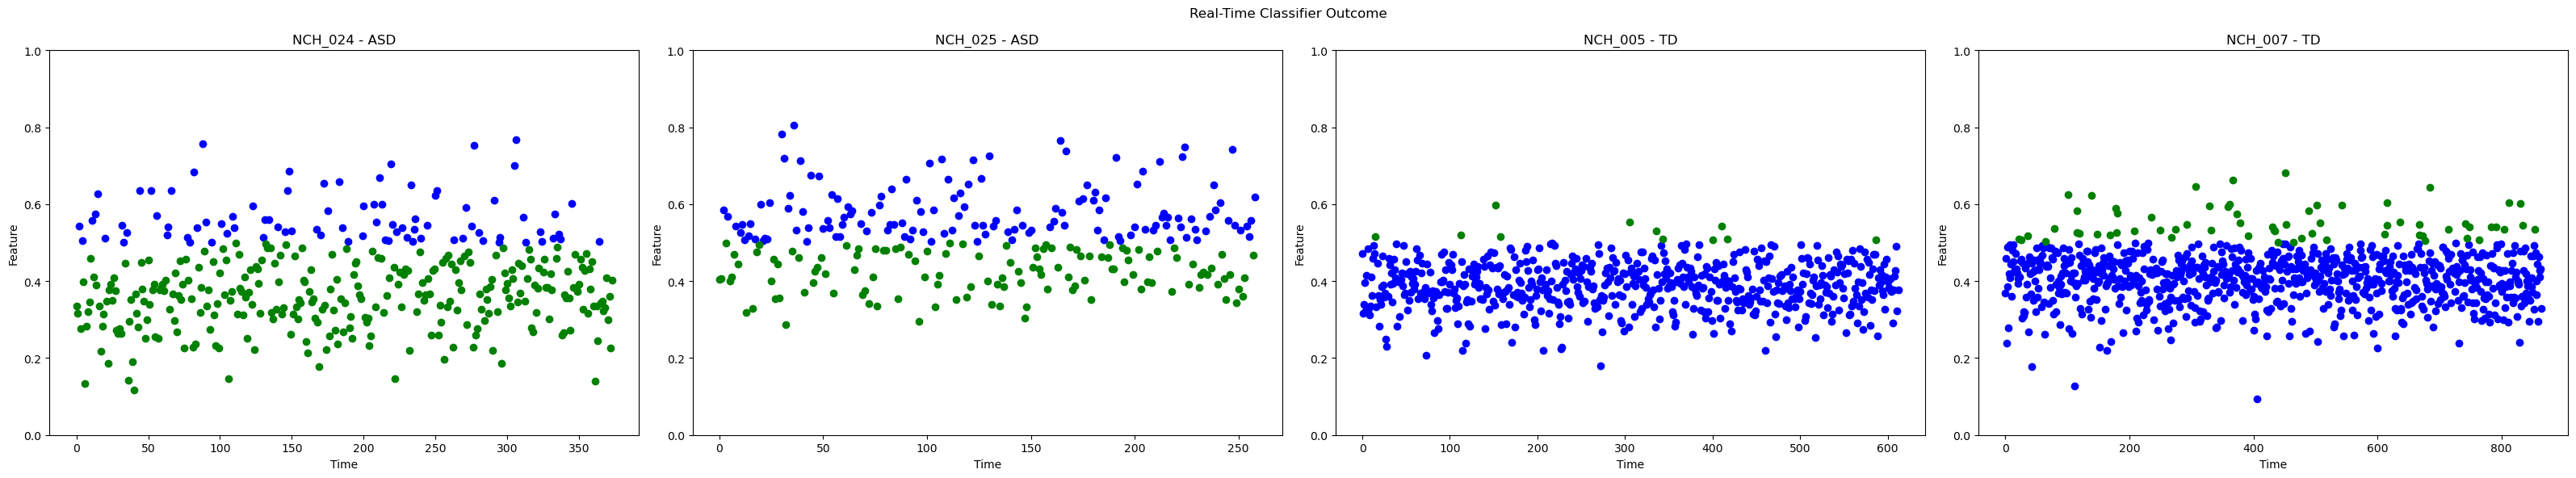

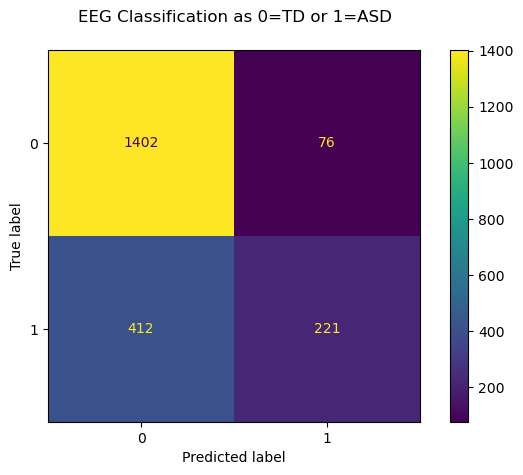

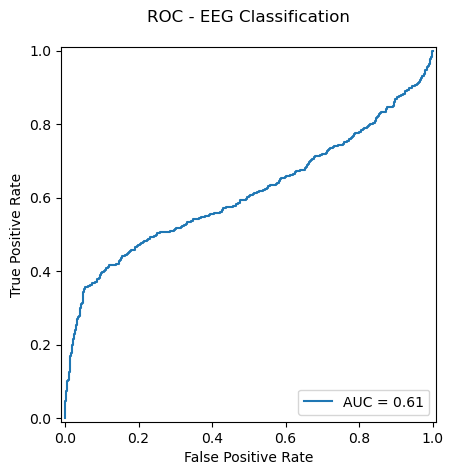

In [101]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_curve, auc

all_srcs = np.concatenate(all_sources).squeeze().astype(int)
all_tgts = np.concatenate(all_targets).squeeze().astype(bool)
all_outs = np.concatenate(all_outputs).squeeze()

labels = ["TD", "ASD"]
srcs = sorted(np.unique(all_srcs))
signals = {}

fig, axs = plt.subplots(1, len(srcs), figsize=(32, 6))
for i, src in enumerate(srcs):
    src_idxs = (all_srcs == src)
    src_tgts = all_tgts[src_idxs]
    src_outs = all_outs[src_idxs]
    xaxis = np.arange(len(src_outs))
    pass_cond = src_tgts == (src_outs >= 0.5)
    fail_cond = src_tgts != (src_outs >= 0.5)
    name = all_labels[src]
    axs[i].scatter(xaxis[pass_cond], src_outs[pass_cond], c="b")
    axs[i].scatter(xaxis[fail_cond], src_outs[fail_cond], c="g")
    axs[i].set(title=f"{name} - {labels[holdout_labels[name]]}", ylim=(0, 1), xlabel="Time", ylabel="Feature")
plt.suptitle("Real-Time Classifier Outcome")
plt.tight_layout()
plt.savefig("test_signals.pdf")
plt.show()
plt.close()

cm = confusion_matrix(all_tgts, all_outs >= 0.5)
ConfusionMatrixDisplay(cm).plot()
plt.suptitle("EEG Classification as 0=TD or 1=ASD")
plt.tight_layout()
plt.savefig("test_cm.pdf")
plt.show()

fpr, tpr, thresh = roc_curve(all_tgts, all_outs)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.suptitle("ROC - EEG Classification")
plt.savefig("test_roc.pdf")
plt.tight_layout()
plt.show()